## XAI untuk UniChart

In [1]:
!pip install -q grad-cam
!pip install -q transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.4 MB/s 

In [2]:
import gdown

file_id = "11v3J8bBhcsodEKJpIXdxJbmkAKxnYNqw"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="jumlah-penduduk.png", quiet=False)

file_id = "1_Jm30P7P9v36i36b13sXlee0Yh8Lh-Qi"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="jumlah-industri.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=11v3J8bBhcsodEKJpIXdxJbmkAKxnYNqw
To: /kaggle/working/jumlah-penduduk.png
100%|██████████| 166k/166k [00:00<00:00, 72.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_Jm30P7P9v36i36b13sXlee0Yh8Lh-Qi
To: /kaggle/working/jumlah-industri.png
100%|██████████| 152k/152k [00:00<00:00, 62.6MB/s]


'jumlah-industri.png'

In [3]:
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from torch.amp import autocast
from transformers import AutoProcessor, VisionEncoderDecoderModel
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, EigenGradCAM, HiResCAM, FinerCAM, LayerCAM, KPCA_CAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
from pytorch_grad_cam.metrics.road import ROADCombined, ROADMostRelevantFirst, ROADLeastRelevantFirst
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage, ROADLeastRelevantFirstAverage

# Wrapper class
class EncoderDecoderWrapper(torch.nn.Module):
    def __init__(self, model, target_token_id):
        super().__init__()
        self.model = model
        self.target_token_id = target_token_id

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values,
                             labels=self.target_token_id)
        target_logits = outputs.logits[:, 0, :]
        return target_logits


def run_multiple_xai_methods(image_path: str, model_name: str, target_text: str, method_names: list = None):
    """
    Menjalankan beberapa metode XAI dan menghasilkan tiga visualisasi untuk setiap metode:
    - Grad-CAM (gc)
    - Guided Backpropagation (gbp)
    - Kombinasi keduanya (gc_gbp)
    
    Menggunakan implementasi resmi ROAD dari pytorch_grad_cam.
    """

    # Setup Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")

    # Muat Model dan Processor
    processor = AutoProcessor.from_pretrained(model_name)
    model = VisionEncoderDecoderModel.from_pretrained(model_name)
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
    if model.config.pad_token_id is None:
        model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.to(device)
    model.eval()

    # Proses Input
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    target_token_ids = processor.tokenizer(target_text, return_tensors="pt").input_ids.to(device)
    target_token_id_for_explanation = target_token_ids[0, 1].item()
    print(f"Target token IDs: {target_token_ids}")
    print(f"Target token ID untuk penjelasan: {target_token_id_for_explanation}")
    print("Dekoding per sub-word token:")
    for token_id in target_token_ids[0]:
        token_id_int = token_id.item()
        token_str = processor.tokenizer.decode([token_id_int])
        print(f"  Token ID: {token_id_int} -> '{token_str}'")

    # Nama file dasar
    image_name = image_path.split("/")[-1].split(".")[0]
    safe_target_text = target_text.replace(" ", "_").lower()

    # Daftar metode yang tersedia
    cam_methods = {
        "gradcam": GradCAM,
        "gradcam++": GradCAMPlusPlus,
        "xgradcam": XGradCAM,
        "eigengradcam": EigenGradCAM,
        "hirescam": HiResCAM,
        'finercam': FinerCAM,
        'layercam': LayerCAM,
        'kpca_cam': KPCA_CAM
    }

    # Default semua metode jika tidak diberikan
    if method_names is None:
        method_names = list(cam_methods.keys())

    # Setup untuk Grad-CAM
    _, _, H, W = pixel_values.shape
    patch_size = model.encoder.config.patch_size
    num_stages = len(model.encoder.encoder.layers)
    downsample_factor = patch_size * (2 ** (num_stages - 1))
    final_h, final_w = H // downsample_factor, W // downsample_factor

    def reshape_transform_robust(tensor):
        result = tensor.reshape(tensor.size(0), final_h, final_w, tensor.size(2))
        return result.permute(0, 3, 1, 2)

    target_layers = [model.encoder.encoder.layers[-1].blocks[-1].layernorm_after]
    model_wrapper = EncoderDecoderWrapper(model, target_token_ids)
    targets = [ClassifierOutputTarget(target_token_id_for_explanation)]

    # Setup ROAD metrics dengan berbagai persentil
    percentiles_to_test = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    
    # Dictionary untuk menyimpan hasil
    morf_scores_detailed = {}
    lerf_scores_detailed = {}
    road_official_scores = {}

    # Looping untuk setiap metode
    for method_name in method_names:
        if method_name not in cam_methods:
            print(f"⚠️ Metode {method_name} tidak dikenal. Lewati.")
            continue

        print(f"\n🔍 Menghasilkan CAM dengan metode: {method_name.upper()}...")

        selected_cam_method = cam_methods[method_name]
        cam = selected_cam_method(
            model=model_wrapper,
            target_layers=target_layers,
            reshape_transform=reshape_transform_robust
        )

        # Hasilkan Grad-CAM
        base_filename = f'{image_name}_{safe_target_text}_{method_name}'
        rgb_img = np.array(image.resize((W, H))) / 255.0
        grayscale_cam = cam(input_tensor=pixel_values, targets=targets)[0, :]
        
        # 1. Grad-CAM saja
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        Image.fromarray(cam_image).save(f'{base_filename}_gc.jpg')
        print(f"✅ Grad-CAM disimpan sebagai '{base_filename}_gc.jpg'")

        # 2. Guided Backpropagation
        print("🧠 Menghasilkan Guided Backpropagation...")
        gb_model = GuidedBackpropReLUModel(model=model_wrapper, device=device)
        gb = gb_model(pixel_values, target_category=target_token_id_for_explanation)
        gb_result = deprocess_image(gb)
        Image.fromarray(gb_result).save(f'{base_filename}_gbp.jpg')
        print(f"✅ GBP disimpan sebagai '{base_filename}_gbp.jpg'")

        # 3. Kombinasi Grad-CAM + Guided Backprop
        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        Image.fromarray(cam_gb).save(f'{base_filename}_gc_gbp.jpg')
        print(f"✅ Gabungan disimpan sebagai '{base_filename}_gc_gbp.jpg'")

        # --- Perhitungan ROAD dengan implementasi resmi ---
        print("📊 Menghitung ROAD dengan implementasi resmi...")
        
        # Siapkan grayscale_cams dalam format yang benar (batch dimension)
        grayscale_cams = np.expand_dims(grayscale_cam, axis=0)
        
        try:
            # 1. ROAD Combined (implementasi resmi)
            road_combined_metric = ROADCombined(percentiles=percentiles_to_test)
            road_combined_score = road_combined_metric(
                input_tensor=pixel_values.detach(),
                cams=grayscale_cams,
                targets=targets,
                model=model_wrapper
            )[0]  # Ambil score untuk sample pertama
            road_official_scores[method_name] = road_combined_score
            print(f"✅ ROAD Combined [{method_name}]: {road_combined_score:.4f}")
            
            # 2. ROAD MORF Average (untuk detail)
            morf_average_metric = ROADMostRelevantFirstAverage(percentiles=percentiles_to_test)
            morf_average_score = morf_average_metric(
                input_tensor=pixel_values.detach(),
                cams=grayscale_cams,
                targets=targets,
                model=model_wrapper
            )[0]
            
            # 3. ROAD LERF Average (untuk detail)
            lerf_average_metric = ROADLeastRelevantFirstAverage(percentiles=percentiles_to_test)
            lerf_average_score = lerf_average_metric(
                input_tensor=pixel_values.detach(),
                cams=grayscale_cams,
                targets=targets,
                model=model_wrapper
            )[0]
            
            print(f"📈 MORF Average [{method_name}]: {morf_average_score:.4f}")
            print(f"📉 LERF Average [{method_name}]: {lerf_average_score:.4f}")
            
            # Simpan score individual per persentil untuk plotting
            morf_individual = []
            lerf_individual = []
            
            for p in percentiles_to_test:
                try:
                    morf_metric = ROADMostRelevantFirst(percentile=p)
                    lerf_metric = ROADLeastRelevantFirst(percentile=p)
                    
                    morf_score = morf_metric(
                        input_tensor=pixel_values.detach(),
                        cams=grayscale_cams,
                        targets=targets,
                        model=model_wrapper
                    )[0]
                    
                    lerf_score = lerf_metric(
                        input_tensor=pixel_values.detach(),
                        cams=grayscale_cams,
                        targets=targets,
                        model=model_wrapper
                    )[0]
                    
                    morf_individual.append(morf_score)
                    lerf_individual.append(lerf_score)
                    
                except Exception as e:
                    print(f"⚠️ Error pada persentil {p}: {e}")
                    morf_individual.append(0.0)
                    lerf_individual.append(0.0)
            
            morf_scores_detailed[method_name] = morf_individual
            lerf_scores_detailed[method_name] = lerf_individual
            
        except Exception as e:
            print(f"❌ Error menghitung ROAD untuk {method_name}: {e}")
            road_official_scores[method_name] = 0.0
            morf_scores_detailed[method_name] = [0.0] * len(percentiles_to_test)
            lerf_scores_detailed[method_name] = [0.0] * len(percentiles_to_test)

    # --- Plotting Hasil ---
    print("\n📈 Membuat plot visualisasi MORF dan LERF...")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
    
    # Plot MORF
    for method_name, scores in morf_scores_detailed.items():
        ax1.plot(percentiles_to_test, scores, marker='o', linestyle='-', label=f"{method_name}")
    ax1.set_title('MORF: Dampak Penghapusan Fitur Paling Relevan', fontsize=14)
    ax1.set_xlabel('% Piksel Dihapus', fontsize=12)
    ax1.set_ylabel('Skor Kepercayaan Model', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot LERF
    for method_name, scores in lerf_scores_detailed.items():
        ax2.plot(percentiles_to_test, scores, marker='o', linestyle='-', label=f"{method_name}")
    ax2.set_title('LERF: Dampak Penghapusan Fitur Tidak Relevan', fontsize=14)
    ax2.set_xlabel('% Piksel Dihapus', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Plot ROAD Official Scores
    methods = list(road_official_scores.keys())
    official_scores = [road_official_scores[m] for m in methods]
    
    x = np.arange(len(methods))
    
    ax3.bar(x, official_scores, alpha=0.8, color='steelblue')
    ax3.set_title('ROAD Scores (Official Implementation)', fontsize=14)
    ax3.set_xlabel('Metode XAI', fontsize=12)
    ax3.set_ylabel('ROAD Score', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(methods, rotation=45, ha='right')
    ax3.grid(True, linestyle='--', alpha=0.6)
    
    # Add value labels on bars
    for i, v in enumerate(official_scores):
        ax3.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    fig.suptitle(f'Analisis Metrik ROAD untuk Target: "{target_text}"', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_filename = f'{image_name}_{safe_target_text}_road_analysis.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot berhasil disimpan sebagai '{plot_filename}'")
    
    # Print summary
    print("\n📋 RINGKASAN HASIL ROAD:")
    print("=" * 40)
    for method_name in methods:
        print(f"{method_name.upper():>12} | ROAD Score: {road_official_scores[method_name]:>8.4f}")
    print("=" * 40)
    
    return {
        'road_scores': road_official_scores,
        'morf_detailed': morf_scores_detailed,
        'lerf_detailed': lerf_scores_detailed
    }

2025-07-30 09:31:26.971510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753867887.149628      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753867887.206146      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Menggunakan device: cuda


preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.


Target token IDs: tensor([[   0, 2643,    2]], device='cuda:0')
Target token ID untuk penjelasan: 2643
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 2643 -> 'industri'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_industri_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_industri_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_industri_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: 0.4746
📈 MORF Average [gradcam]: -2.2188
📉 LERF Average [gradcam]: -1.2058

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_industri_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_industri_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_industri_hirescam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi

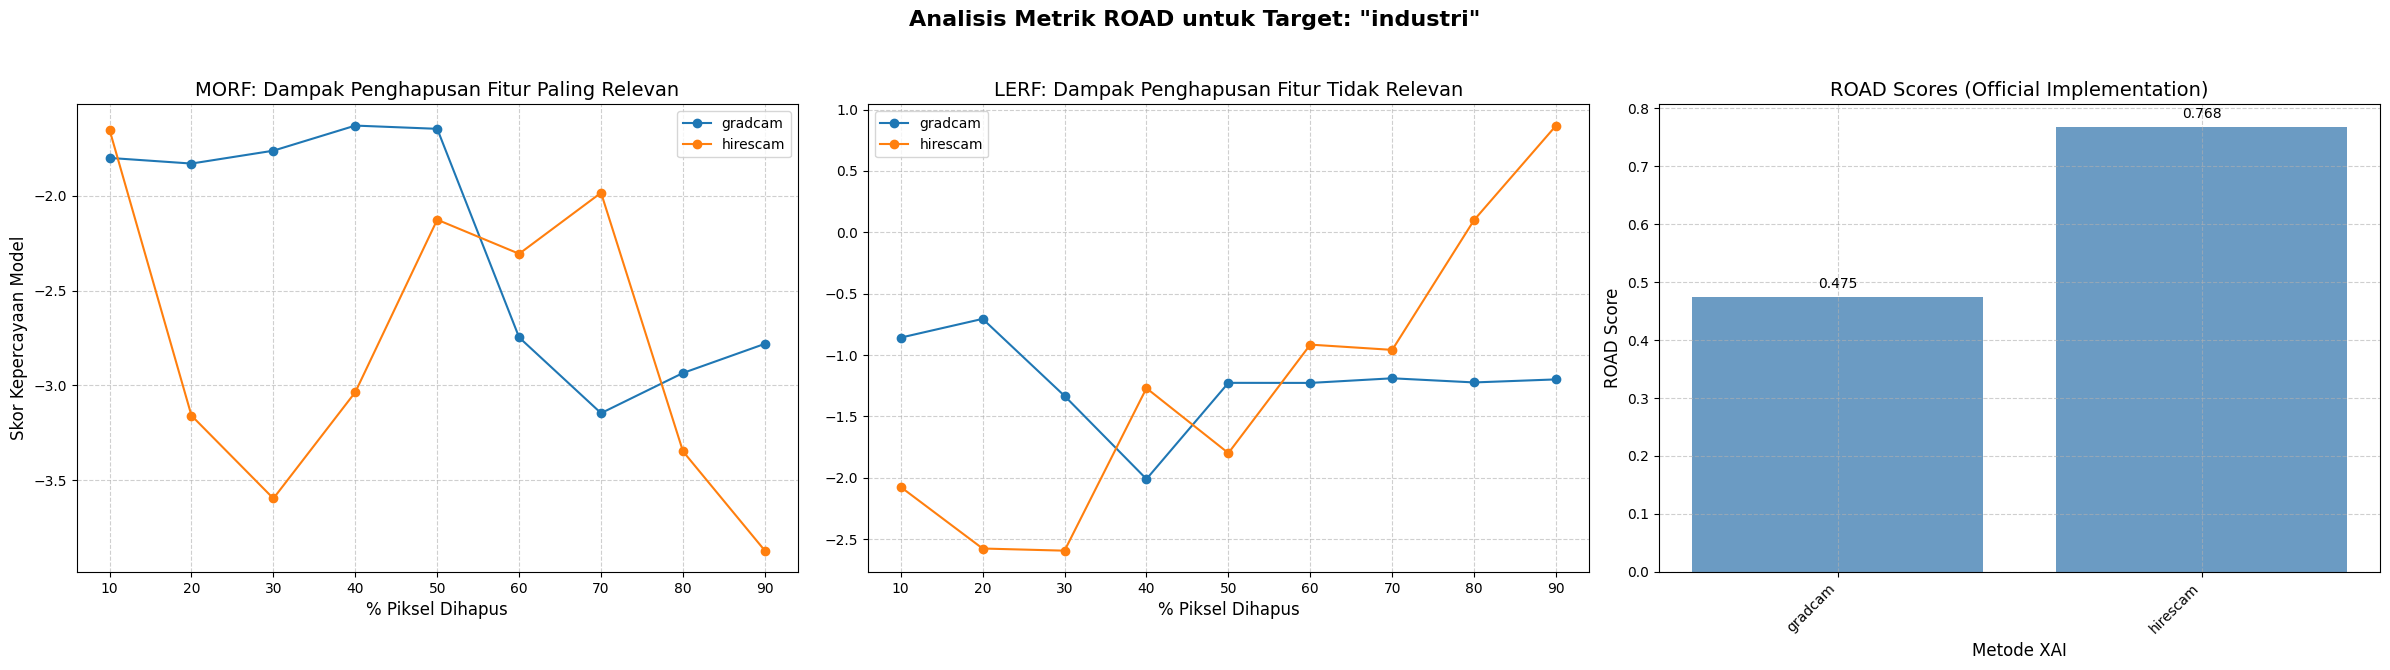

In [4]:
# Define paramater
image_path='/kaggle/working/jumlah-industri.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="industri"

# Contoh penggunaan
results = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name, 
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

Menggunakan device: cuda


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Target token IDs: tensor([[    0, 41634, 36858,     2]], device='cuda:0')
Target token ID untuk penjelasan: 41634
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 41634 -> 'ban'
  Token ID: 36858 -> 'yak'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_banyak_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_banyak_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_banyak_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: 0.1259
📈 MORF Average [gradcam]: -1.0336
📉 LERF Average [gradcam]: -0.7881

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_banyak_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_banyak_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_banyak_hirescam_gc_gbp.jpg'
📊 Menghitung ROAD den

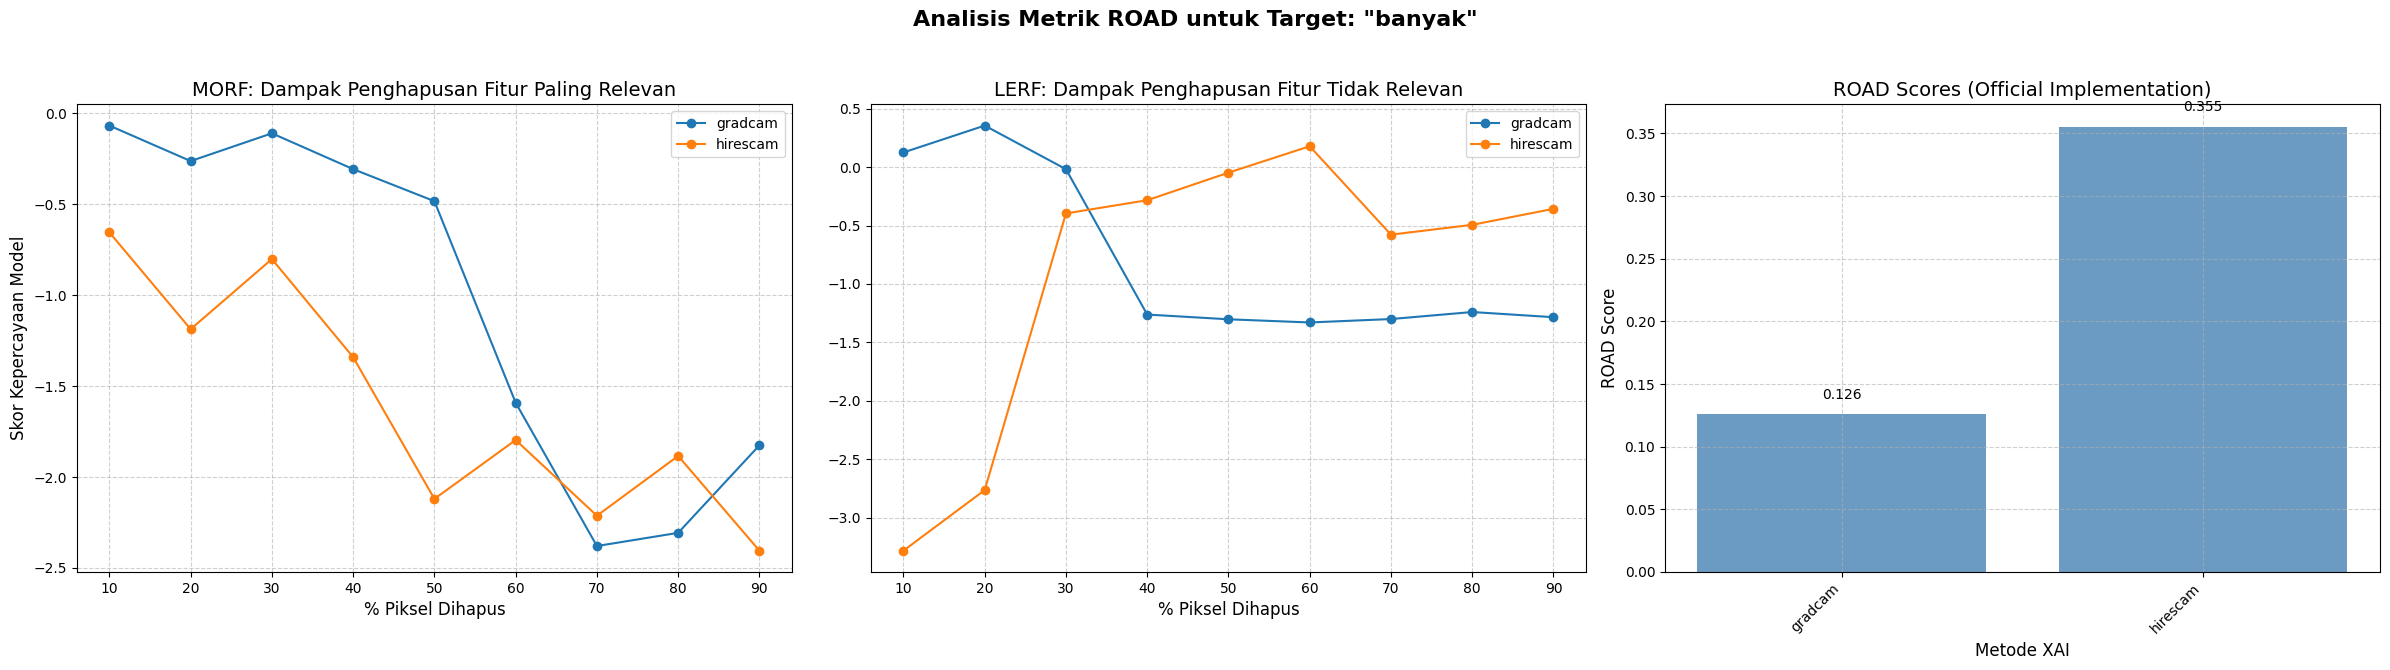

In [5]:
# Define paramater
image_path='/kaggle/working/jumlah-industri.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="banyak"

# Jalankan beberapa metode
scores = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name,
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

Menggunakan device: cuda


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Target token IDs: tensor([[    0, 46137, 11699,     2]], device='cuda:0')
Target token ID untuk penjelasan: 46137
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 46137 -> '2.3'
  Token ID: 11699 -> '94'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_2.394_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_2.394_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_2.394_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: 0.6555
📈 MORF Average [gradcam]: -2.5429
📉 LERF Average [gradcam]: -1.1898

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-industri_2.394_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-industri_2.394_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-industri_2.394_hirescam_gc_gbp.jpg'
📊 Menghitung ROAD dengan imp

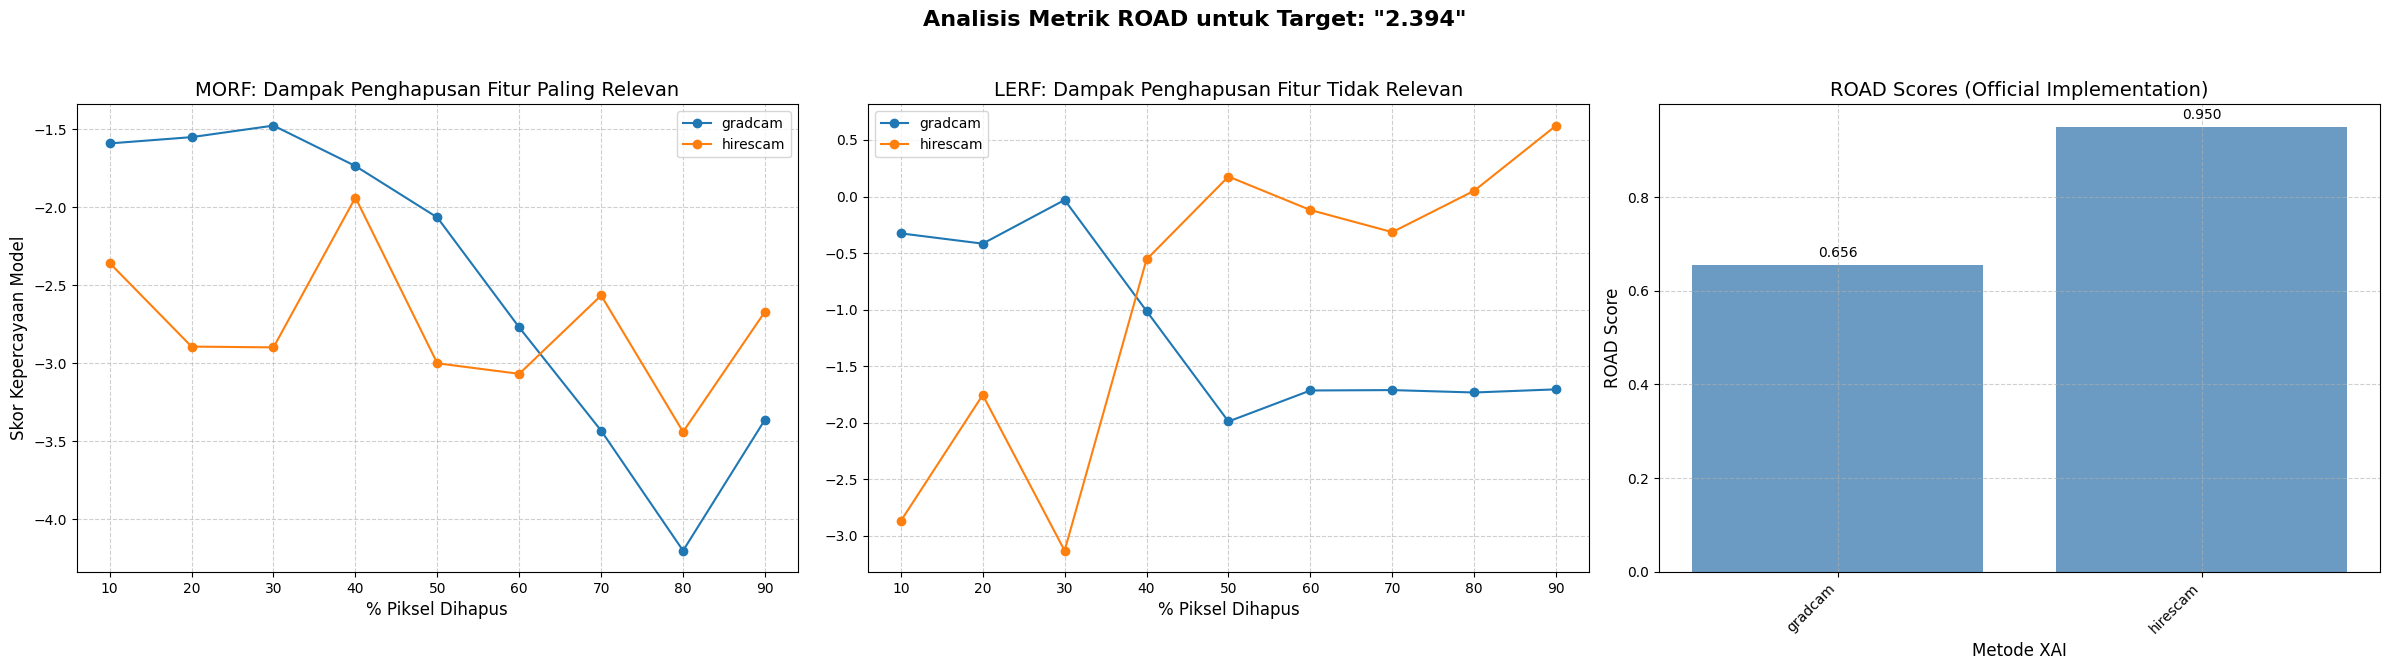

In [6]:
# Define paramater
image_path='/kaggle/working/jumlah-industri.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="2.394"

# Jalankan beberapa metode
scores = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name,
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

Menggunakan device: cuda


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Target token IDs: tensor([[    0, 43431, 36967,  4898,     2]], device='cuda:0')
Target token ID untuk penjelasan: 43431
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 43431 -> 'pend'
  Token ID: 36967 -> 'u'
  Token ID: 4898 -> 'duk'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_penduduk_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_penduduk_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-penduduk_penduduk_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: -0.6612
📈 MORF Average [gradcam]: -0.9563
📉 LERF Average [gradcam]: -2.2722

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_penduduk_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_penduduk_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-penduduk_pendud

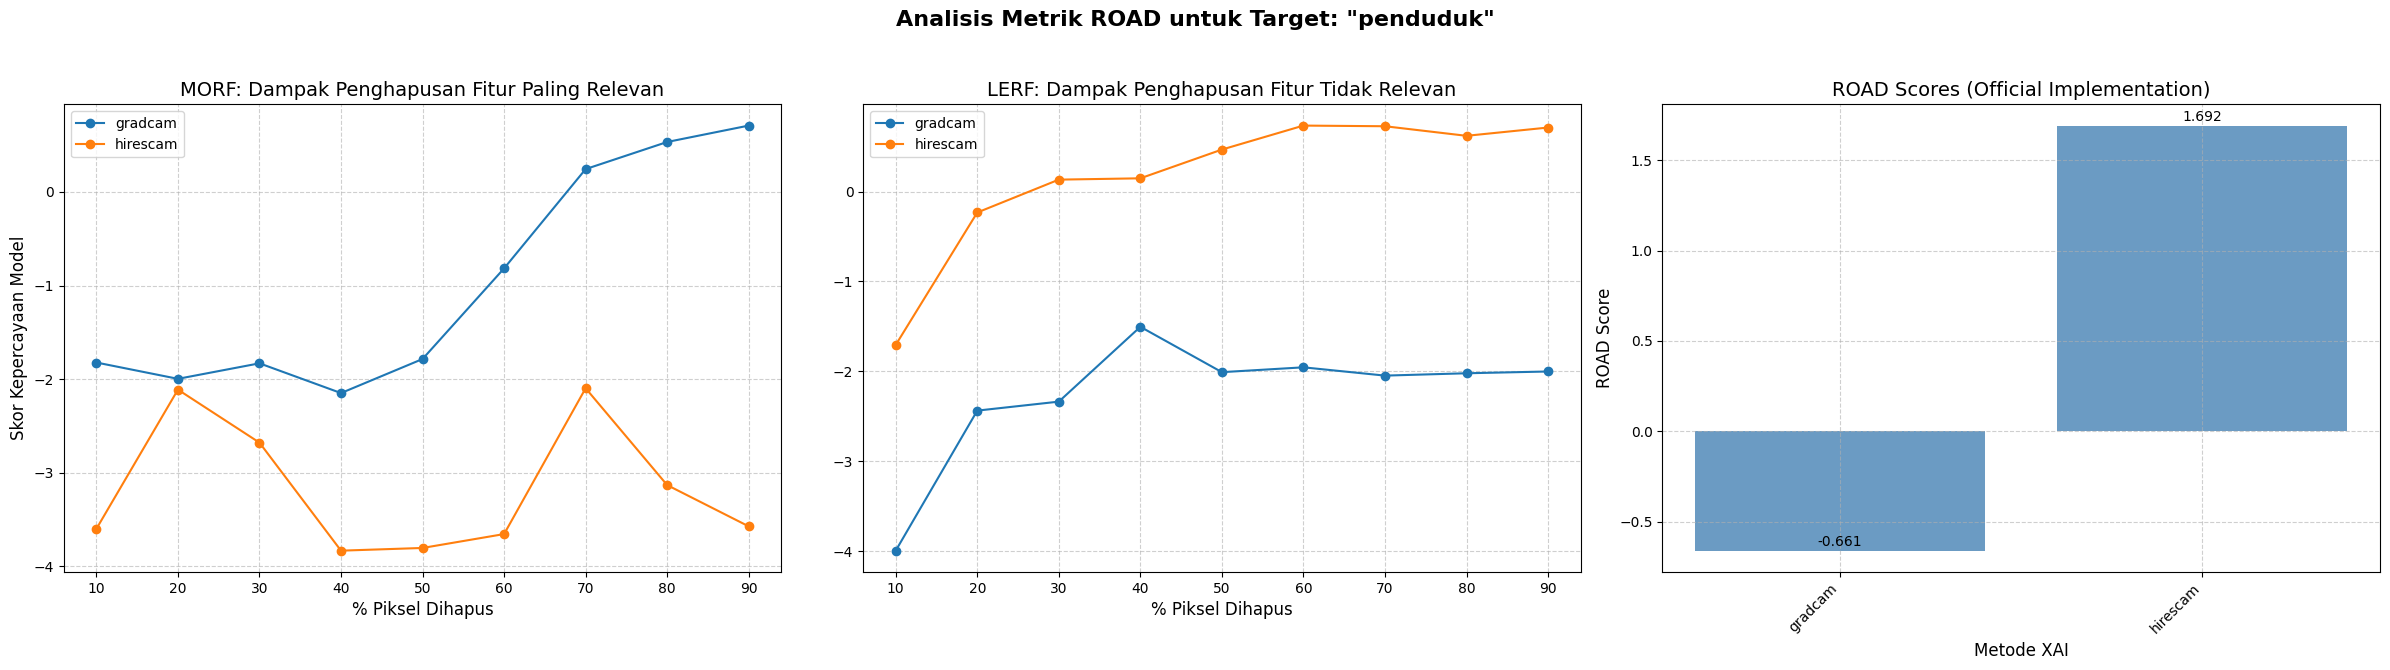

In [7]:
# Define paramater
image_path='/kaggle/working/jumlah-penduduk.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="penduduk"

# Jalankan beberapa metode
scores = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name,
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

Menggunakan device: cuda


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Target token IDs: tensor([[    0, 39212, 35248, 24854,     2]], device='cuda:0')
Target token ID untuk penjelasan: 39212
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 39212 -> 'se'
  Token ID: 35248 -> 'dik'
  Token ID: 24854 -> 'it'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_sedikit_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_sedikit_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-penduduk_sedikit_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: -0.3270
📈 MORF Average [gradcam]: -1.0975
📉 LERF Average [gradcam]: -1.8193

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_sedikit_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_sedikit_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-penduduk_sedikit_hir

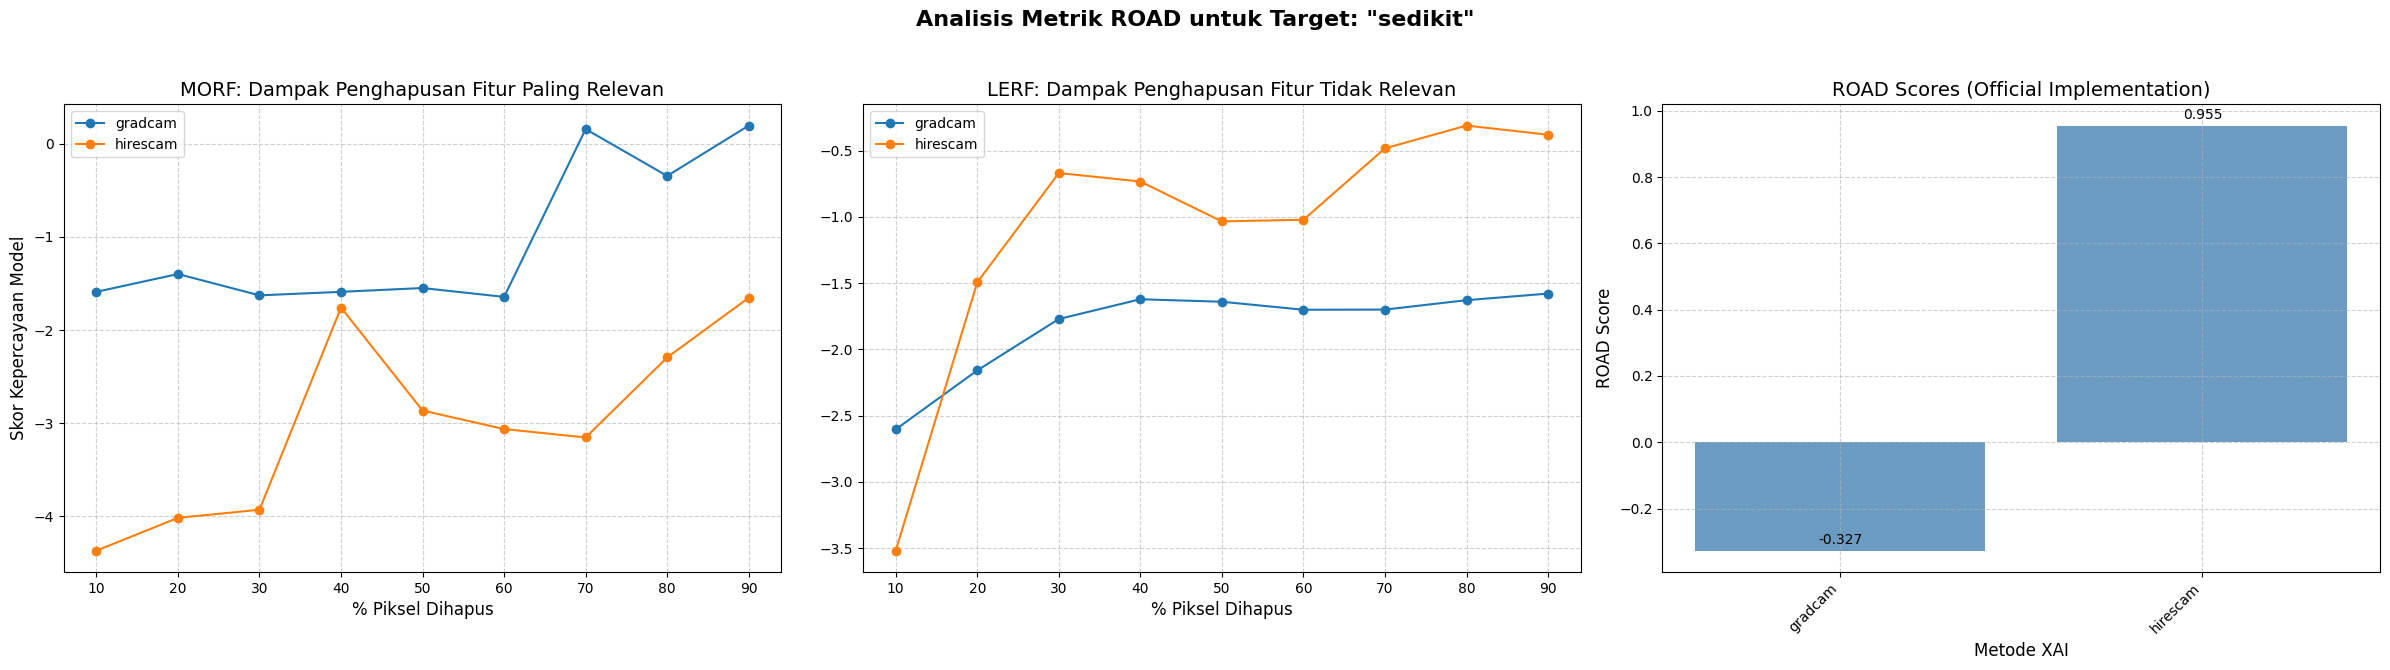

In [8]:
# Define paramater
image_path='/kaggle/working/jumlah-penduduk.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="sedikit"

# Jalankan beberapa metode
scores = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name,
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

Menggunakan device: cuda


Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    960,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.47.0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_f

Target token IDs: tensor([[    0, 52285, 39539,   486, 18590,     2]], device='cuda:0')
Target token ID untuk penjelasan: 52285
Dekoding per sub-word token:
  Token ID: 0 -> '<s>'
  Token ID: 52285 -> '100'
  Token ID: 39539 -> '.'
  Token ID: 486 -> '8'
  Token ID: 18590 -> '18'
  Token ID: 2 -> '</s>'

🔍 Menghasilkan CAM dengan metode: GRADCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_100.818_gradcam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_100.818_gradcam_gbp.jpg'
✅ Gabungan disimpan sebagai 'jumlah-penduduk_100.818_gradcam_gc_gbp.jpg'
📊 Menghitung ROAD dengan implementasi resmi...
✅ ROAD Combined [gradcam]: 0.7380
📈 MORF Average [gradcam]: -2.5093
📉 LERF Average [gradcam]: -1.0187

🔍 Menghasilkan CAM dengan metode: HIRESCAM...
✅ Grad-CAM disimpan sebagai 'jumlah-penduduk_100.818_hirescam_gc.jpg'
🧠 Menghasilkan Guided Backpropagation...
✅ GBP disimpan sebagai 'jumlah-penduduk_100.818_hirescam_gbp.jpg'
✅ Gabungan disimpan sebagai 

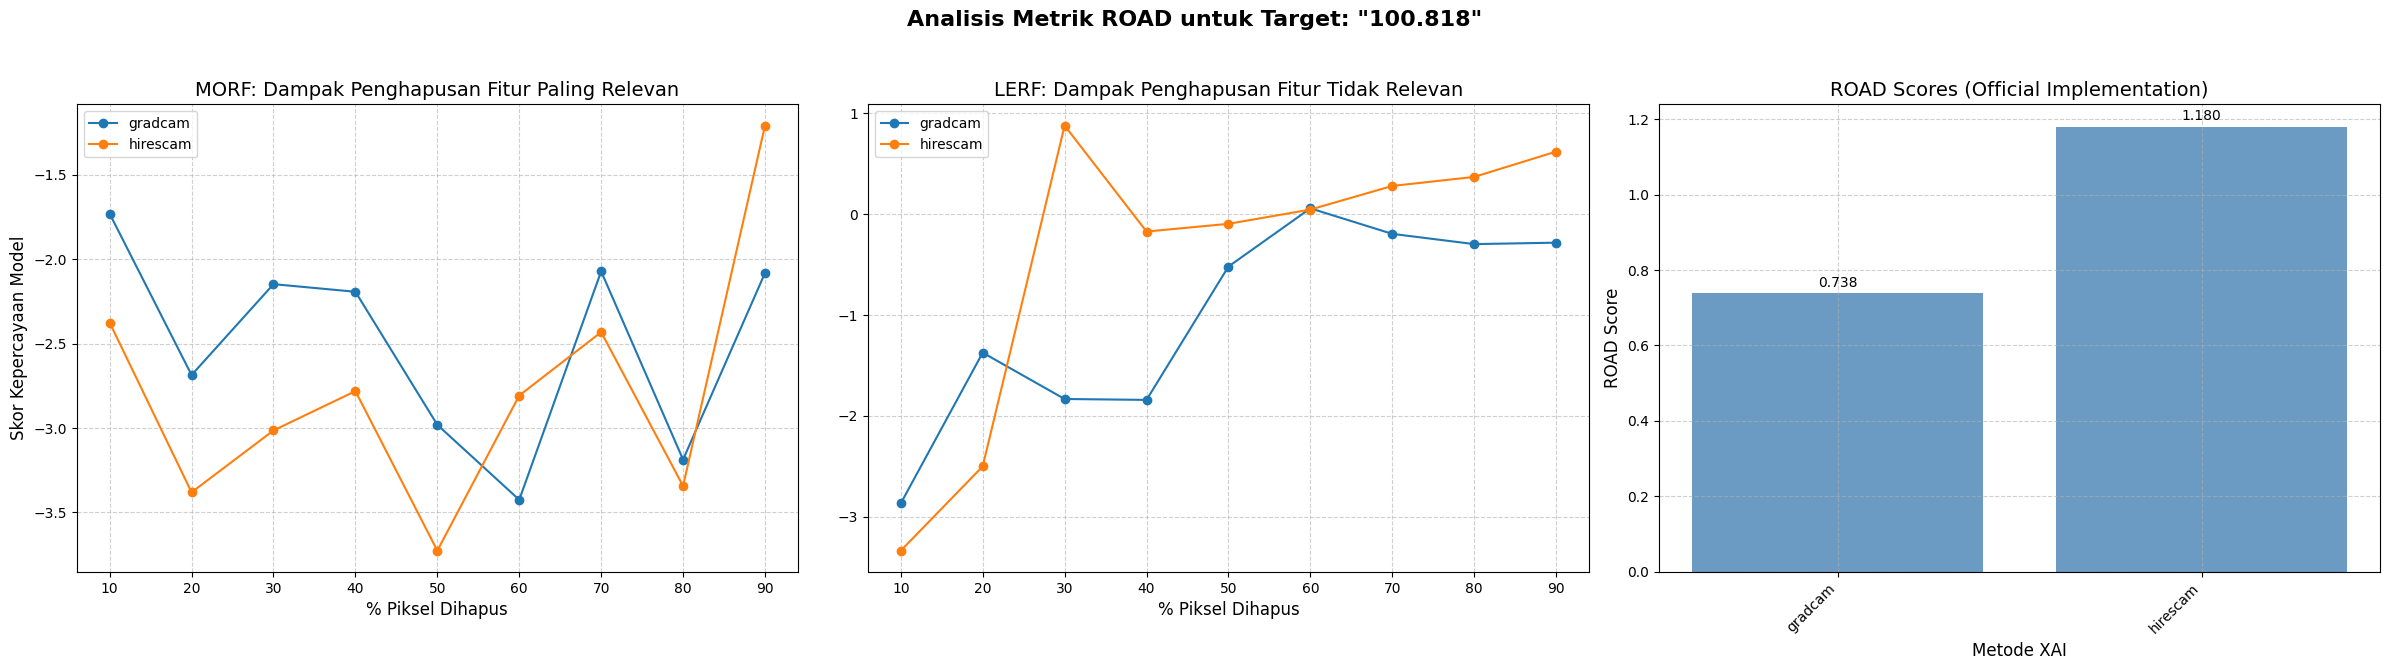

In [9]:
# Define paramater
image_path='/kaggle/working/jumlah-penduduk.png'
model_name='akunskripsiapillv1/finetuned-unichart-indochart-v2'
target_text="100.818"

# Jalankan beberapa metode
scores = run_multiple_xai_methods(
    image_path=image_path,
    model_name=model_name,
    target_text=target_text,
    method_names=["gradcam", "hirescam"]
)

## XAI untuk ChartInstruct-Llama

In [10]:
# !pip install -q bitsandbytes

In [11]:
# # llava_wrapper.py
# import torch

# class LlavaWrapper(torch.nn.Module):
#     """
#     Wrapper untuk LlavaForConditionalGeneration (dengan atau tanpa PeftModel)
#     agar kompatibel dengan pustaka pytorch_grad_cam.
#     """
#     def __init__(self, model, target_token_id, processor, prompt_text=None):
#         """
#         Args:
#             model: Model LlavaForConditionalGeneration yang sudah dimuat dan digabung (merged).
#             target_token_id (int or torch.Tensor): ID token target untuk penjelasan.
#             processor: Processor (LlavaProcessor) yang digunakan untuk tokenisasi.
#             prompt_text (str, optional): Prompt tetap. Default sesuai deskripsi.
#         """
#         super().__init__()
#         self.model = model
#         self.processor = processor
#         self.target_token_id = target_token_id.item() if isinstance(target_token_id, torch.Tensor) else target_token_id
        
#         # Prompt default atau dari parameter
#         self.prompt_text = prompt_text or "<image>\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer:"
        
#         # Tokenisasi prompt sekali saja saat inisialisasi untuk efisiensi
#         with torch.no_grad():
#             text_inputs = self.processor(text=self.prompt_text, return_tensors='pt')
#             # Gunakan register_buffer untuk menyimpan di device yang sama dengan model
#             self.register_buffer('input_ids', text_inputs['input_ids'])
#             self.register_buffer('attention_mask', text_inputs['attention_mask'])

#     def forward(self, pixel_values):
#         """
#         Forward pass untuk menghitung logit.
#         Args:
#             pixel_values (torch.Tensor): Tensor gambar yang sudah diproses.
#         Returns:
#             torch.Tensor: Logit dari seluruh vocab di posisi terakhir, bentuk [batch_size, vocab_size].
#         """
#         device = pixel_values.device
        
#         input_ids = self.input_ids.to(device)
#         attention_mask = self.attention_mask.to(device)

#         # --- GUNAKAN torch.enable_grad() secara eksplisit ---
#         # Ini memastikan gradien dihitung untuk operasi dalam blok ini,
#         # bahkan jika ada torch.no_grad() di luar atau model.eval().
#         with torch.enable_grad(): # <-- PERUBAHAN PENTING
#             outputs = self.model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 pixel_values=pixel_values,
#                 output_hidden_states=True,
#                 return_dict=True
#             )
        
#         logits = outputs.logits
#         last_logits = logits[:, -1, :] # [batch_size, vocab_size]
        
#         # last_logits sekarang harus memiliki grad_fn
#         print(f"Logits grad_fn: {last_logits.grad_fn}") # Untuk debugging
#         print(f"Pixel values requires_grad: {pixel_values.requires_grad}")
#         print(f"Logits shape: {last_logits.shape}, grad_fn: {last_logits.grad_fn}")
        
#         return last_logits

In [12]:
# # load_model.py
# import torch
# from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
# from peft import PeftModel

# def load_model(base_model_path, adapter_path):
#     """
#     Memuat base model LLaVA, menerapkan adapter PEFT, 
#     dan menggabungkannya menjadi satu model standar.
#     """
#     processor = AutoProcessor.from_pretrained(base_model_path)

#     quant_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.float16
#     )

#     # Muat model dasar dengan kuantisasi
#     base_model = LlavaForConditionalGeneration.from_pretrained(
#         base_model_path,
#         torch_dtype=torch.float16,
#         # quantization_config=quant_config,
#     )

#     # Muat adapter LoRA di atas model dasar
#     print("Menerapkan adapter PEFT...")
#     model = PeftModel.from_pretrained(base_model, adapter_path)

#     # Gabungkan adapter ke dalam bobot dasar
#     print("Menggabungkan (merge) adapter ke model dasar...")
#     model = model.merge_and_unload()

#     model.to("cuda")
#     model.eval()
#     print("Model dan processor berhasil dimuat, digabung, dan dipindahkan ke CUDA.")
#     return model, processor

In [13]:
# import torch
# import numpy as np
# from PIL import Image
# import cv2
# import os

# # Import pustaka Grad-CAM
# from pytorch_grad_cam import (
#     GradCAM, GradCAMPlusPlus, XGradCAM, EigenGradCAM, HiResCAM,
#     ShapleyCAM, FinerCAM #, AblationCAM # Hati-hati dengan memori
# )
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
# from pytorch_grad_cam.metrics.road import ROADCombined

# def run_multiple_xai_methods(
#     image_path: str,
#     model,          # Model yang sudah dimuat dan digabung
#     processor,      # Processor yang sudah dimuat
#     target_text: str,
#     method_names: list = None
# ):
#     """
#     Menjalankan beberapa metode XAI pada model LLaVA dan menghasilkan visualisasi.
    
#     Args:
#         image_path (str): Path ke file gambar input.
#         model: Model LlavaForConditionalGeneration yang sudah dimuat dan digabung.
#         processor: Processor (LlavaProcessor) yang sudah dimuat.
#         target_text (str): Teks target untuk mendapatkan target_token_id.
#         method_names (list, optional): Daftar nama metode CAM. Default semua.
        
#     Returns:
#         dict: Dictionary berisi skor ROAD untuk setiap metode.
#     """
#     # 1. Setup Device
#     device = next(model.parameters()).device # Dapatkan device dari model
#     print(f"Menggunakan device: {device}")

#     # 2. Validasi input
#     if not os.path.exists(image_path):
#         raise FileNotFoundError(f"File gambar tidak ditemukan: {image_path}")
#     if model is None or processor is None:
#         raise ValueError("Model dan processor harus disediakan.")

#     # 3. Proses Input Gambar dan Teks Target
#     image = Image.open(image_path).convert("RGB")
    
#     # Tokenisasi target_text untuk mendapatkan target_token_id
#     target_token_ids = processor.tokenizer(target_text, return_tensors="pt").input_ids.to(device)
#     # Ambil token pertama setelah BOS (index 1)
#     target_token_id_for_explanation = target_token_ids[0, 1].item()
#     print(f"Target token ID untuk penjelasan: {target_token_id_for_explanation} ('{processor.tokenizer.decode([target_token_id_for_explanation])}')")

#     # 4. Siapkan Prompt dan Input untuk Model
#     prompt_text = "<image>\n Question: Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif Answer:"
#     inputs = processor(text=prompt_text, images=[image], return_tensors="pt").to(device)
        
#     pixel_values = inputs['pixel_values']
#     if pixel_values.dtype != torch.float16:
#         pixel_values = pixel_values.to(torch.float16)

#     if not pixel_values.requires_grad:
#         pixel_values.requires_grad_(True)

#     print(f"Tipe data pixel_values: {pixel_values.dtype}")

#     # 5. Setup untuk Grad-CAM
#     image_name = os.path.splitext(os.path.basename(image_path))[0]

#     cam_methods = {
#         "gradcam": GradCAM,
#         "gradcam++": GradCAMPlusPlus,
#         "xgradcam": XGradCAM,
#         "eigengradcam": EigenGradCAM,
#         "hirescam": HiResCAM,
#         'shapleycam': ShapleyCAM,
#         'finercam': FinerCAM,
#         # "ablationcam": AblationCAM,
#     }

#     if method_names is None:
#         method_names = list(cam_methods.keys())

#     # --- Konfigurasi Target Layer dan Reshape Transform ---
#     # Berdasarkan struktur model dari knowledge base: Swin Transformer
#     # vision_tower -> encoder -> layers (ModuleList) -> [-1] -> blocks (ModuleList) -> [-1] -> layernorm_after
#     try:
#         target_layers = [model.vision_tower.encoder.layers[-1].blocks[-1].layernorm_after]
#         print(f"Target layer diatur ke: {type(target_layers[0]).__name__}")
#     except AttributeError as e:
#         raise ValueError("Tidak dapat menemukan target layer yang sesuai. Periksa struktur model.") from e

#     # --- Reshape Transform untuk Swin Transformer ---
#     final_h, final_w = 16, 16
#     print(f"🔧 Mengatur reshape transform untuk feature map: {final_h}x{final_w} ({final_h * final_w} tokens)")

#     # Di dalam reshape_transform_robust, tambahkan:
#     def reshape_transform_robust(tensor):
#         """Reshape dan transpose tensor dari Swin Transformer."""
#         batch_size, num_tokens, hidden_dim = tensor.size()
#         print(f"🔍 Tensor CAM diterima: {tensor.shape}")
#         expected_tokens = final_h * final_w
#         if num_tokens != expected_tokens:
#             print(f"⚠️  Jumlah token tidak sesuai: {num_tokens} (diharapkan: {expected_tokens}).")
#             # Opsional: Coba infer ukuran secara dinamis
#             # Misalnya, jika num_tokens = 256, maka H=W=16
#             import math
#             inferred_h = inferred_w = int(math.sqrt(num_tokens))
#             if inferred_h * inferred_w == num_tokens:
#                 print(f"🔧 Menginfer ukuran feature map menjadi: {inferred_h}x{inferred_w}")
#                 result = tensor.view(batch_size, inferred_h, inferred_w, hidden_dim)
#                 return result.permute(0, 3, 1, 2)
#             else:
#                 raise ValueError(f"Unexpected number of tokens: {num_tokens}. Cannot infer HxW.")
#         result = tensor.view(batch_size, final_h, final_w, hidden_dim)
#         result = result.permute(0, 3, 1, 2) # [B, H, W, C] -> [B, C, H, W]
#         return result

#     # --- Inisialisasi Wrapper ---
#     model_wrapper = LlavaWrapper(model, target_token_id_for_explanation, processor, prompt_text)
#     targets = [ClassifierOutputTarget(target_token_id_for_explanation)]
    
#     # Dapatkan dimensi gambar untuk visualisasi
#     _, _, H, W = pixel_values.shape
#     rgb_img = np.array(image.resize((W, H)), dtype=np.float32) / 255.0

#     # 6. Dictionary untuk menyimpan skor ROAD
#     road_scores = {}

#     # 7. Looping untuk setiap metode
#     for method_name in method_names:
#         if method_name not in cam_methods:
#             print(f"⚠️ Metode {method_name} tidak dikenal. Lewati.")
#             continue

#         print(f"\n🔍 Menghasilkan CAM dengan metode: {method_name.upper()}...")

#         selected_cam_method = cam_methods[method_name]

#         cam = selected_cam_method(
#             model=model_wrapper,
#             target_layers=target_layers,
#             reshape_transform=reshape_transform_robust
#         )

#         # Hasilkan Grad-CAM
#         grayscale_cam = cam(input_tensor=pixel_values, targets=targets)[0, :]
        
#         # --- Simpan Visualisasi ---
#         base_filename = f'{image_name}_{method_name}'
        
#         # 1. Grad-CAM saja
#         cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
#         Image.fromarray(cam_image).save(f'{base_filename}_gc.jpg')
#         print(f"✅ Grad-CAM disimpan sebagai '{base_filename}_gc.jpg'")

#         # 2. Guided Backpropagation
#         print("🧠 Menghasilkan Guided Backpropagation...")
#         from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
#         gb_model = GuidedBackpropReLUModel(model=model_wrapper, device=device)
#         gb = gb_model(pixel_values, target_category=target_token_id_for_explanation)
#         gb_result = deprocess_image(gb)
#         Image.fromarray(gb_result).save(f'{base_filename}_gbp.jpg')
#         print(f"✅ GBP disimpan sebagai '{base_filename}_gbp.jpg'")

#         # 3. Kombinasi Grad-CAM + Guided Backprop
#         cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
#         cam_gb = deprocess_image(cam_mask * gb)
#         Image.fromarray(cam_gb).save(f'{base_filename}_gc_gbp.jpg')
#         print(f"✅ Gabungan disimpan sebagai '{base_filename}_gc_gbp.jpg'")

#         # --- Evaluasi dengan ROAD ---
#         print("📊 Menghitung skor evaluasi dengan metrik ROAD...")
#         cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
#         cams_for_metric = np.expand_dims(grayscale_cam, axis=0)
#         try:
#             scores = cam_metric(
#                 input_tensor=pixel_values.detach(),
#                 cams=cams_for_metric,
#                 targets=targets,
#                 model=model_wrapper
#             )
#             road_score = scores[0]
#             road_scores[method_name] = road_score
#             print(f"📈 Skor Kualitas Penjelasan (ROAD Combined) [{method_name}]: {road_score:.4f}")
#         except Exception as e:
#             print(f"❌ Gagal menghitung skor ROAD untuk {method_name}: {e}")
#             road_scores[method_name] = float('nan')

#     return road_scores


In [14]:
# # --- 1. Parameter ---
# BASE_MODEL_PATH = "ahmed-masry/ChartInstruct-LLama2"
# ADAPTER_PATH = "akunskripsiapillv1/finetuned-chartinstruct-llama-v2"
# IMAGE_PATH = "/kaggle/working/jumlah-industri.png"
# TARGET_TEXT = "Klojen"

# # --- 2. Muat Model dan Processor ---
# print("Memuat dan menggabungkan model...")
# model, processor = load_model(BASE_MODEL_PATH, ADAPTER_PATH)

In [15]:
# # --- 3. Jalankan XAI ---
# print("Menjalankan pipeline XAI...")
# scores = run_multiple_xai_methods(
#     image_path=IMAGE_PATH,
#     model=model,
#     processor=processor,
#     target_text=TARGET_TEXT,
#     method_names=["gradcam", "gradcam++", "xgradcam"] # Pilih metode
# )

# # --- 4. Cetak Hasil ---
# print("\n--- Hasil Skor ROAD ---")
# for method, score in scores.items():
#     print(f"{method.upper()}: {score:.4f}")